<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#mlp-regression" data-toc-modified-id="mlp-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>mlp regression</a></span><ul class="toc-item"><li><span><a href="#regularization-&amp;-hyperparameters-tuning" data-toc-modified-id="regularization-&amp;-hyperparameters-tuning-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>regularization &amp; hyperparameters tuning</a></span></li></ul></li><li><span><a href="#pinn" data-toc-modified-id="pinn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>pinn</a></span></li></ul></div>

# tl;dr

In this notebook we will try to write code for a PINN that solves the Damped Harmonic Oscillator problem using parameter learning approach. We will compare the results with a MLP regression model.

# setup

In [1]:
import pprint
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from IPython.display import display

%matplotlib inline

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Damped Harmonic Oscillator Dataset by Cecília Coelho](https://www.kaggle.com/datasets/cici118/damped-harmonic-oscillator)

* $m = 1kg$
* $k = 1 N m^{-1}$
* $\mu = 0.1 N s m^{-1}$
* $x_0 = 1 m$
* $v_0 = 0 m s^{-1}$

,time,displacement,velocity,acceleration
0,0.000000,1.000000,0.000000,-1.000000
1,1.507538,0.106701,-0.926586,-0.014042
2,3.015075,-0.847175,-0.111879,0.858363
3,4.522613,-0.194060,0.783410,0.115719
4,6.030151,0.705190,0.190814,-0.724272
5,7.537689,0.252050,-0.650740,-0.186976
6,9.045226,-0.576071,-0.242684,0.600339
7,10.552764,-0.286335,0.530372,0.233298
8,12.060302,0.460883,0.272761,-0.488160
9,13.567840,0.301914,-0.423218,-0.259593


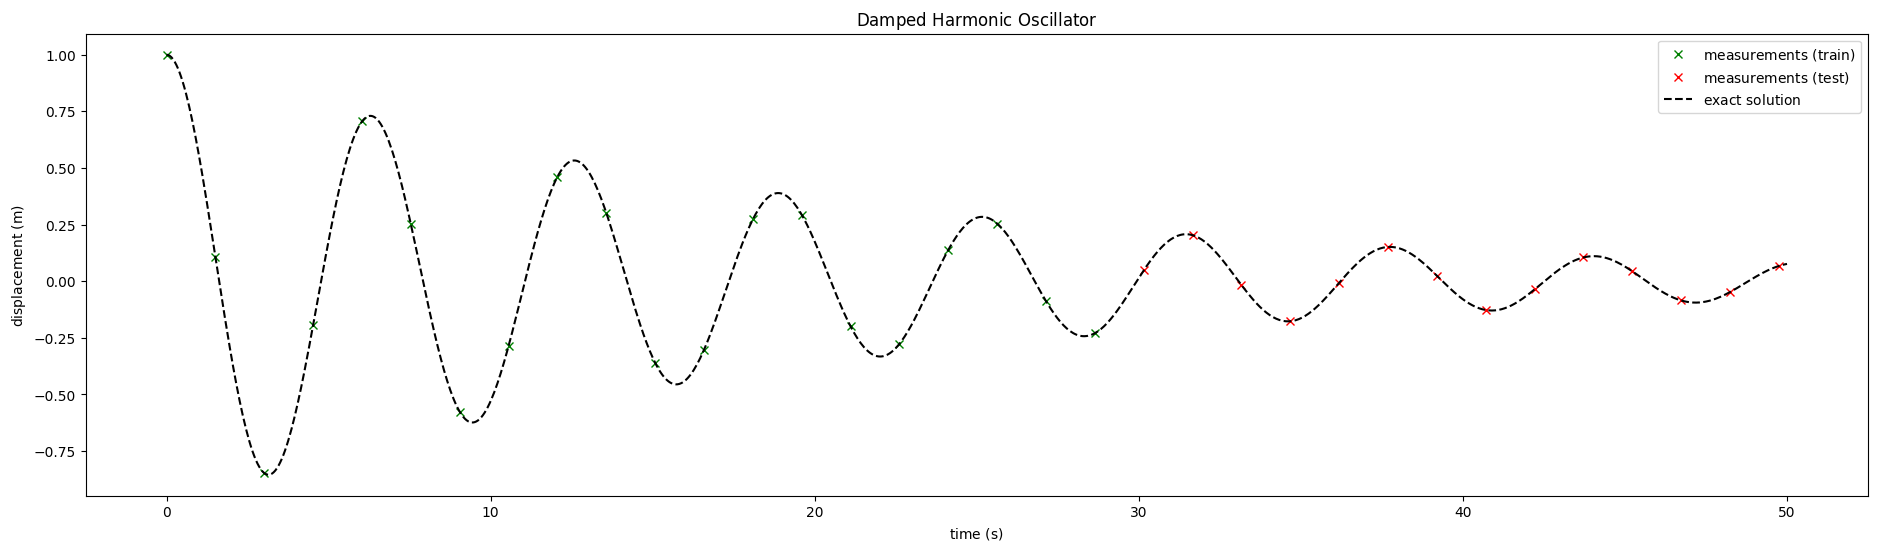

In [2]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")
display(X)

# plot experimental data
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico.png", dpi=300, bbox_inches="tight") ;

.